In [1]:
# importing libraries which will be required during this project.
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data
aord = pd.read_csv("aord.csv")
nikkei = pd.read_csv("nikkei.csv")
hsi = pd.read_csv("hsi.csv")
spy = pd.read_csv("spy.csv")

In [3]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,146.529999,146.990005,143.880005,144.929993,116.593864,204935600
1,2008-01-03,144.910004,145.490005,144.070007,144.860001,116.537567,125133300
2,2008-01-04,143.339996,143.440002,140.910004,141.309998,113.681671,232330900
3,2008-01-07,141.809998,142.229996,140.100006,141.190002,113.585121,234991000
4,2008-01-08,142.080002,142.899994,138.440002,138.910004,111.750923,326365700


In [4]:
print(aord.head())
print(nikkei.head())
print(hsi.head())

         Date         Open         High          Low        Close  \
0  2008-01-01  6418.600098  6462.799805  6408.399902  6434.100098   
1  2008-01-02  6422.700195  6422.700195  6335.799805  6372.600098   
2  2008-01-03  6387.700195  6421.200195  6355.000000  6385.399902   
3  2008-01-06  6357.799805  6357.799805  6227.700195  6240.399902   
4  2008-01-07  6233.200195  6259.700195  6195.299805  6205.700195   

     Adj Close       Volume  
0  6434.100098  365493500.0  
1  6372.600098  511702600.0  
2  6385.399902  627840800.0  
3  6240.399902  692737000.0  
4  6205.700195  772191800.0  
         Date          Open          High           Low         Close  \
0  2008-01-04  15155.730469  15156.660156  14542.580078  14691.410156   
1  2008-01-07  14549.379883  14667.849609  14438.610352  14500.549805   
2  2008-01-08  14429.299805  14547.799805  14365.860352  14528.669922   
3  2008-01-09  14364.709961  14602.650391  14271.570313  14599.160156   
4  2008-01-10  14546.320313  14584.73046

In [5]:
print("aord",aord.shape)
print("nikkei",nikkei.shape)
print("hsi",hsi.shape)
print("spy",spy.shape)

aord (2689, 7)
nikkei (2622, 7)
hsi (2629, 7)
spy (2679, 7)


Above you can see that all market have different lengths, it is because all market have different holidays. Our aim is to predict "SPY" based on other markets to decide either we should be long(buy position) or short(sell position). So, we will consider only those days when SPY was open.

We will create new dataframe which will be having proportion change ({close price - open price}/open price) of  different markets on a particular day. And we will predict proportion change in SPY(Target Variable) using proportion change in other markets(Predictors).

In [6]:
spy.set_index(["Date"],inplace =True)
aord.set_index(["Date"],inplace = True)
nikkei.set_index(["Date"],inplace = True)
hsi.set_index(["Date"],inplace = True)

In [7]:
market_data = pd.DataFrame(index = spy.index)

In [8]:
market_data["spy"] = (spy["Close"] - spy["Open"])/spy["Open"]
market_data["aord"] = (aord["Close"] - aord["Open"])/aord["Open"]
market_data["nikkei"] = (nikkei["Close"] - nikkei["Open"])/nikkei["Open"]
market_data["hsi"] = (hsi["Close"] - hsi["Open"])/hsi["Open"]

In [9]:
market_data.head()

,spy,aord,nikkei,hsi
Date,,,,
2008-01-02,-0.010919,-0.007800,NaN,-0.002594
2008-01-03,-0.000345,-0.000360,NaN,-0.006017
2008-01-04,-0.014162,NaN,-0.030637,0.019084
2008-01-07,-0.004372,-0.004412,-0.003356,0.008046
2008-01-08,-0.022311,-0.005474,0.006887,-0.012890


There are some NaN values because we have taken SPY["Date"] as index. So for some days we will not have other markets' data because all markets have different holidays. We will fill NaN values by forward filling method. And will drop initial rows which don't have value to fill. 

In [10]:
market_data = market_data.fillna(method = "ffill")
market_data=market_data.dropna()

In [11]:
market_data.isna().sum()

spy       0
aord      0
nikkei    0
hsi       0
dtype: int64

In [12]:
market_data.shape

(2677, 4)

Let us split data into Test,Train and Validation.

In [13]:
Train = market_data.iloc[-2677:-1300, :]
Test =market_data.iloc[-1300:, :]

In [14]:
Train.head()

,spy,aord,nikkei,hsi
Date,,,,
2008-01-04,-0.014162,-0.000360,-0.030637,0.019084
2008-01-07,-0.004372,-0.004412,-0.003356,0.008046
2008-01-08,-0.022311,-0.005474,0.006887,-0.012890
2008-01-09,0.009203,-0.002094,0.016321,0.028619
2008-01-10,0.011526,-0.016281,-0.010876,-0.007130


Let us check correlation between our target variable and predictors.

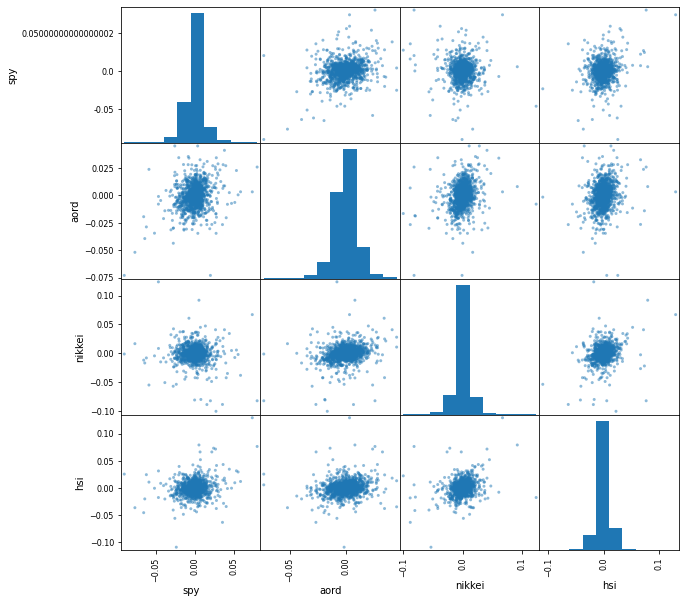

In [15]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train,figsize=(10,10))

In [16]:
Train.corr()

,spy,aord,nikkei,hsi
spy,1.000000,0.247580,-0.052478,0.191482
aord,0.247580,1.000000,0.244187,0.188449
nikkei,-0.052478,0.244187,1.000000,0.271766
hsi,0.191482,0.188449,0.271766,1.000000


Not much higher correlation but for stock market it is enough to generate profit. Let us build model.

In [17]:
formula = 'spy ~ aord + nikkei + hsi'
lm = smf.ols(formula = formula,data = Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     55.03
Date:                Sat, 23 Oct 2021   Prob (F-statistic):           1.37e-33
Time:                        19:03:31   Log-Likelihood:                 4163.3
No. Observations:                1377   AIC:                            -8319.
Df Residuals:                    1373   BIC:                            -8298.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.532      0.595      -0.000       0.001
aord           0.2913      0.031      9.516      0.000       0.231       0.351
nikkei        -0.1487      0.024     -6.112      0.000      -0.196      -0.101
hsi            0.1761      0.025      7.068      0.000       0.127       0.225
==============================================================================
Omnibus:                      204.836   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1984.622
Skew:                          -0.348   Prob(JB):                         0.00
Kurtosis:                       8.840   Cond. No.                         99.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All coefficient are significant as we can see from p values. R**2 is less but enough for stock market data to generate profit.

Let us predict on Train,Test and Validation data.

In [18]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

Let us evaluate our model. We will use RMSE and Adjusted R^2 as our evaluation parameteres.

In [19]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [20]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [21]:
assessTable(Test, Train, lm, 3, 'spy')

,Train,Test
R2,0.105384,0.182286
RMSE,0.011785,0.006497


As our model gives similar values of evalution parameters for all data. We can consider it as consistent and an unbiased model.

Let us now build trading strategy for our model. We will take long position on any day if our model predicted proportion change as positive and will take short position if our model predicted proportion change as negative and will square off our position at end of the day. We will trade only one share per day. We will create new column Order which will have two values 1 & -1. 1 means long and -1 means short.

In [22]:
Train["Order"] = [1 if i>0 else -1 for i in Train["PredictedY"]]

In [23]:
Train["Open"] = spy.loc[Train.index,"Open"]

In [24]:
# this will represent profit in absolute value.
Train["Profit"] = Train["Order"]*(Train["Open"]*Train["spy"])

In [25]:
# this will give cumulative wealth till any day.
Train["Wealth"] = Train["Profit"].cumsum()

In [26]:
Train.tail()

,spy,aord,nikkei,hsi,PredictedY,yhat,Order,Open,Profit,Wealth
Date,,,,,,,,,,
2013-06-18,0.007354,-0.002164,-0.000605,0.005842,0.000657,0.000657,1,164.529999,1.210006,294.509823
2013-06-19,-0.012983,0.009844,0.000917,-0.009510,0.001226,0.001226,1,165.600006,-2.150009,292.359814
2013-06-20,-0.015198,-0.020220,-0.006661,-0.013834,-0.007167,-0.007167,-1,161.860001,2.460007,294.819821
2013-06-21,-0.003570,-0.004174,0.034584,0.014689,-0.003603,-0.003603,-1,159.639999,0.569992,295.389813
2013-06-24,-0.002224,-0.015390,-0.026440,-0.010461,-0.002225,-0.002225,-1,157.410004,0.350006,295.739819


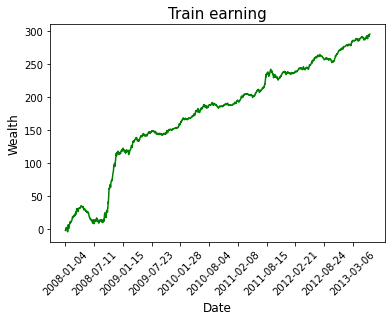

In [27]:
plt.plot(Train["Wealth"],color = "green")
x_ticks = []
for i in range(11):
    x_ticks.append(Train.index[i*130])
plt.xticks(ticks=x_ticks,rotation =45)
plt.xlabel("Date",size =12)
plt.ylabel("Wealth",size=12)
plt.title("Train earning",size=15)
plt.show()

Suppose we have adopted buy and hold position strategy from day 1 to the last day of Train period. Then our profit would have been SPY closing price on last day minus SPY opening price on first day. Let us calculate that profit and call it as passive wealth.

In [28]:
Train_Passive_wealth = spy.loc["2013-06-24","Close"] - spy.loc["2008-01-04","Open"]
print(Train_Passive_wealth)

13.720002000000022


As we can see that if we would have gone in passive way, we could have made only 13.72. As per our strategy we are making 295.73. Let us calculate wealth in Test period.

In [29]:
Test["Order"] = [1 if i>0 else -1 for i in Test["PredictedY"]]
Test["Open"] = spy.loc[Test.index,"Open"] 
Test["Profit"] = Test["Order"]*(Test["Open"]*Test["spy"])
Test["Wealth"] = Test["Profit"].cumsum()

In [30]:
Test.head()

,spy,aord,nikkei,hsi,PredictedY,yhat,Order,Open,Profit,Wealth
Date,,,,,,,,,,
2013-06-25,0.000568,-0.003784,-0.008583,0.004032,0.001053,0.001053,1,158.479996,0.090011,0.090011
2013-06-26,0.001689,0.016035,-0.024234,0.012334,0.010615,0.010615,1,159.869995,0.270004,0.360015
2013-06-27,-0.000124,0.016356,0.018879,-0.000801,0.001986,0.001986,1,161.100006,-0.020004,0.340011
2013-06-28,-0.001307,-0.001965,0.021922,0.010034,-0.001896,-0.001896,-1,160.630005,0.210007,0.550018
2013-07-01,0.000620,-0.017946,0.007695,0.010034,-0.004437,-0.004437,-1,161.259995,-0.100006,0.450012


In [31]:
Test.tail()

,spy,aord,nikkei,hsi,PredictedY,yhat,Order,Open,Profit,Wealth
Date,,,,,,,,,,
2018-08-15,-0.002125,0.004619,-0.007327,-0.014468,0.000057,0.000057,1,282.380005,-0.600006,182.990053
2018-08-16,0.002329,-0.000483,0.009609,0.008520,0.000100,0.000100,1,283.399994,0.660004,183.650057
2018-08-17,0.004334,0.002121,-0.001919,-0.006395,-0.000054,-0.000054,-1,283.829987,-1.230011,182.420046
2018-08-20,0.000350,0.001447,-0.003057,0.011888,0.003138,0.003138,1,285.570007,0.100006,182.520052
2018-08-21,0.000314,-0.008096,0.004938,0.002972,-0.002401,-0.002401,-1,286.250000,-0.089996,182.430056


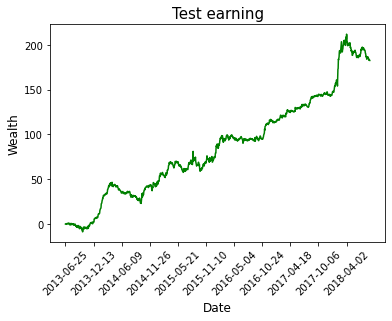

In [32]:
plt.plot(Test["Wealth"],color = "green")
x_ticks = []
for i in range(11):
    x_ticks.append(Test.index[i*120])
plt.xticks(ticks=x_ticks,rotation =45)
plt.xlabel("Date",size =12)
plt.ylabel("Wealth",size=12)
plt.title("Test earning",size=15)
plt.show()

In [33]:
Test_Passive_wealth = spy.loc["2018-08-21","Close"] - spy.loc["2013-06-25","Open"]
print(Test_Passive_wealth)

127.85999999999999


Also in test data, we are seeing good result. Let us calculate total combine wealth of Train and Test and also combine passive wealth.

In [34]:
total_strategy_wealth = Train.iloc[-1,9] + Test.iloc[-1,9]
print(total_strategy_wealth)

478.16987500000033


In [35]:
total_passive_wealth = spy.loc["2018-08-21","Close"] - spy.loc["2008-01-04","Open"]
print(total_passive_wealth)

143.0


let us now calculate returns in terms of %. For passive, we will consider 1st day opening price as investment and for our strategy we will take avg of all days opening price as investment. 

In [36]:
#passive return
passive_returns =  (spy.loc["2018-08-21","Close"] - spy.loc["2008-01-04","Open"])/spy.loc["2008-01-04","Open"]*100
print(passive_returns)

99.76280451410088


In [37]:
total_strategy_returns =  total_strategy_wealth/spy["Open"].mean()*100
print(total_strategy_returns)

284.40351174069656


So, Passive strategy has given approximately 100% returns where as our strategy has given approximately 285% returns during given time. 